# Reddit Research - Taoism
## Unsupervised Topic Modeling

In [1]:
pip install bertopic sentence-transformers scikit-learn plotly

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install openai

Note: you may need to restart the kernel to use updated packages.


In [5]:
pip install ipywidgets

Note: you may need to restart the kernel to use updated packages.


In [7]:
pip install dotenv

In [9]:
!pip install --upgrade nbformat

In [10]:
import pandas as pd

In [11]:
# Load preprocessed data
comments_df = pd.read_csv("../data/taoism_comments_cleaned.csv")
texts_cleaned = [str(t) for t in comments_df['clean_text'].fillna("").tolist()]

In [15]:
from bertopic import BERTopic

# Initialize and fit the model
topic_model = BERTopic(language="english", verbose=True)
topics, probs = topic_model.fit_transform(texts_cleaned)

2025-05-17 10:38:08,854 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/63 [00:00<?, ?it/s]

2025-05-17 10:38:33,411 - BERTopic - Embedding - Completed ✓
2025-05-17 10:38:33,413 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-05-17 10:38:50,688 - BERTopic - Dimensionality - Completed ✓
2025-05-17 10:38:50,690 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-05-17 10:38:50,822 - BERTopic - Cluster - Completed ✓
2025-05-17 10:38:50,826 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-05-17 10:38:50,947 - BERTopic - Representation - Completed ✓


In [16]:
topic_model.get_topic_info().head(10)

,Topic,Count,Name,Representation,Representative_Docs
0,-1,779,-1_like_think_thing_life,"[like, think, thing, life, way, daoism, people...",[tell people tend search belief god resonate f...
1,0,227,0_tao_taoism_taoist_ching,"[tao, taoism, taoist, ching, people, understan...",[literally understanding chinese culture perio...
2,1,90,1_translation_text_chinese_mitchell,"[translation, text, chinese, mitchell, transla...",[well understanding text english translation o...
3,2,54,2_interesting_agree_yes_okay,"[interesting, agree, yes, okay, true, nicely, ...","[interesting know, interesting point, interest..."
4,3,53,3_breath_breathing_meditation_energy,"[breath, breathing, meditation, energy, breath...",[congratulation figure small portion meditatio...
5,4,49,4_time_job_work_desire,"[time, job, work, desire, help, life, find, ou...",[thank take time reply appreciate find perspec...
6,5,48,5_heaven_earth_yin_guo,"[heaven, earth, yin, guo, yang, sky, line, gre...",[lot discuss metaphysical disputable presume r...
7,6,39,6_fold_laundry_clothe_chore,"[fold, laundry, clothe, chore, feel, boxer, th...",[agree way think problem way fold laundry cour...
8,7,35,7_carrot_hello_lol_free,"[carrot, hello, lol, free, name, long, , , , ]","[lol, hello, carrot]"
9,8,35,8_confucius_confucianism_confucian_family,"[confucius, confucianism, confucian, family, s...",[read wikipedia page confucius source power hu...


In [21]:
topic_model.get_topic(3)

[('breath', np.float64(0.046378423876471)),
 ('breathing', np.float64(0.03218049491946427)),
 ('meditation', np.float64(0.03142067099503282)),
 ('energy', np.float64(0.030241257412539916)),
 ('breathe', np.float64(0.026299545095923436)),
 ('spiritual', np.float64(0.025040770815981446)),
 ('body', np.float64(0.024832839350690028)),
 ('cycle', np.float64(0.022213438343126852)),
 ('circle', np.float64(0.019912593736358283)),
 ('work', np.float64(0.01832829235010995))]

In [31]:
fig = topic_model.visualize_topics()
fig.write_html("topic_visualization.html")

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

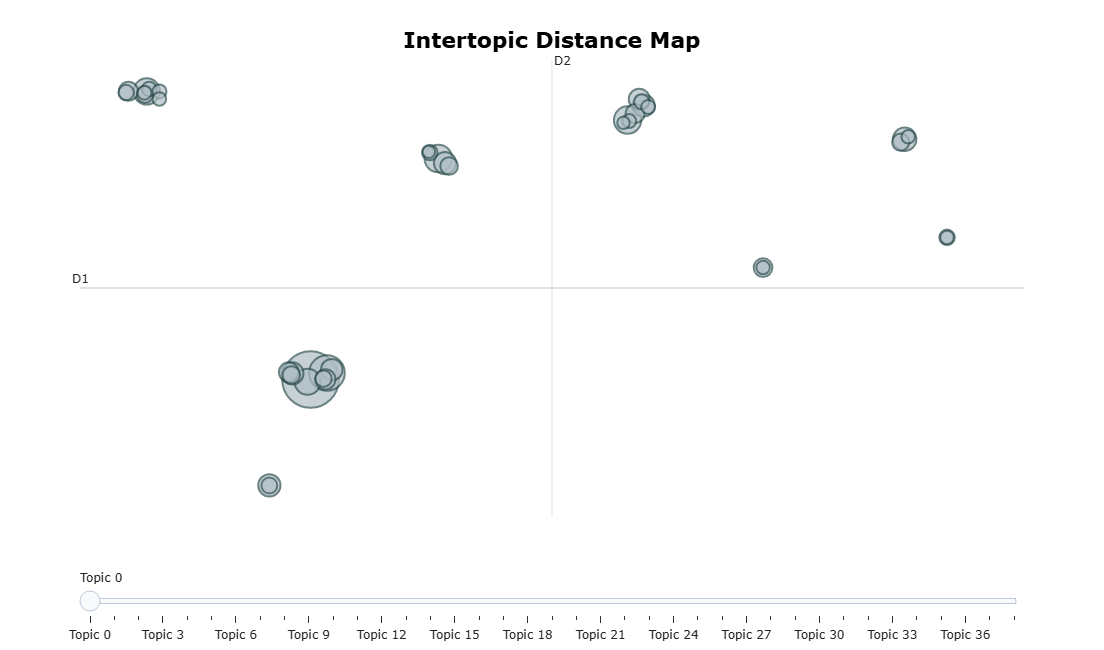

In [33]:
topic_model.visualize_topics()

In [35]:
# Saving the model 
topic_model.save("../models/bertopic_taoism_model")

2025-05-17 10:44:58,908 - BERTopic - WARNING: When you use `pickle` to save/load a BERTopic model,please make sure that the environments in which you saveand load the model are **exactly** the same. The version of BERTopic,its dependencies, and python need to remain the same.


In [37]:
import pickle
import os

os.makedirs("../data/bertopic_outputs", exist_ok=True)

with open("../data/bertopic_outputs/topics.pkl", "wb") as f:
    pickle.dump(topics, f)

with open("../data/bertopic_outputs/probs.pkl", "wb") as f:
    pickle.dump(probs, f)

In [47]:
import openai
from openai import OpenAI
import os
from dotenv import load_dotenv
from collections import defaultdict

In [49]:
load_dotenv()
client = OpenAI(api_key=os.getenv("OPENAI_API_KEY"))

In [51]:
# Create dictionary of topic keywords and example comments
topic_summaries = defaultdict(dict)

for topic_id in topic_model.get_topic_info()[topic_model.get_topic_info().Topic != -1].Topic:
    keywords = topic_model.get_topic(topic_id)
    top_words = [word for word, _ in keywords[:10]]
    docs = topic_model.get_representative_docs(topic_id)[:3]

    topic_summaries[topic_id]["keywords"] = top_words
    topic_summaries[topic_id]["examples"] = docs

In [53]:
def build_prompt(keywords, examples):
    return f"""
You are an AI system assisting in a research project on digital religion, specifically analyzing online discourse around Taoism.

Your task is to generate clear, descriptive topic labels for clusters of Reddit comments, based on semantic patterns. These labels will help identify affective and thematic patterns in how users engage with Taoist ideas in a digital context. The goal is to uncover emergent, community-shaped themes in contemporary Taoist discourse on Reddit, without imposing preexisting philosophical categories.

For each cluster, you are given:
1. A list of the most representative keywords.
2. Three example comments written by real users.

Please analyze both the keywords and the language in the examples. Based on this, generate a **concise and meaningful topic label** (2–5 words) that captures the central theme or emotional tone of the cluster.

Respond with **only** the label. Do not include any explanations or extra text.

**Keywords:** {', '.join(keywords)}

**Examples:**
{chr(10).join(examples)}
"""


In [55]:
topic_labels = {}

for topic_id, content in topic_summaries.items():
    print(f"Labeling topic {topic_id}...")
    prompt = build_prompt(content["keywords"], content["examples"])

    response = client.chat.completions.create(
        model="gpt-4-turbo",
        messages=[{"role": "user", "content": prompt}],
        temperature=0.4
    )

    label = response.choices[0].message.content.strip()
    topic_labels[topic_id] = label


Labeling topic 0...
Labeling topic 1...
Labeling topic 2...
Labeling topic 3...
Labeling topic 4...
Labeling topic 5...
Labeling topic 6...
Labeling topic 7...
Labeling topic 8...
Labeling topic 9...
Labeling topic 10...
Labeling topic 11...
Labeling topic 12...
Labeling topic 13...
Labeling topic 14...
Labeling topic 15...
Labeling topic 16...
Labeling topic 17...
Labeling topic 18...
Labeling topic 19...
Labeling topic 20...
Labeling topic 21...
Labeling topic 22...
Labeling topic 23...
Labeling topic 24...
Labeling topic 25...
Labeling topic 26...
Labeling topic 27...
Labeling topic 28...
Labeling topic 29...
Labeling topic 30...
Labeling topic 31...
Labeling topic 32...
Labeling topic 33...
Labeling topic 34...
Labeling topic 35...
Labeling topic 36...
Labeling topic 37...
Labeling topic 38...


In [57]:
for topic_id, label in topic_labels.items():
    print(f"Topic {topic_id}: :{label}")

Topic 0: :Understanding Taoism Through Textual Interpretation
Topic 1: :Translation Quality and Fidelity in Taoism Texts
Topic 2: :Engagement in Discussion Validity
Topic 3: :Breathing Techniques and Meditation
Topic 4: :Balancing Desire and Contentment
Topic 5: :Metaphysical Interpretations of Taoism
Topic 6: :Mindfulness in Mundane Chores
Topic 7: :Casual Greetings and Humor
Topic 8: :Confucian Sociopolitical Discourse
Topic 9: :Taoist Practice vs. Book Knowledge
Topic 10: :Theistic Interpretations of Taoism
Topic 11: :Ryokan Poetry Recommendations
Topic 12: :Perception and Representation Limitations
Topic 13: :Taoist Philosophical Narratives
Topic 14: :Gender Dynamics and Yin-Yang Balance
Topic 15: :Taoist Practice and Non-Attachment
Topic 16: :Effortlessness in Action
Topic 17: :Gratitude and Positive Celebrations
Topic 18: :[Data Redaction and Apologies]
Topic 19: :Comparing Taoism and Legalism
Topic 20: :Dao as Water: Flow and Humility
Topic 21: :Taoist Philosophy on Naturalness 

In [59]:
import pandas as pd
import json

with open("../data/topic_labels_gpt.json", "w") as f:
    json.dump(topic_labels, f, indent=2)

pd.DataFrame(list(topic_labels.items()), columns=["topic", "label"]).to_csv("../data/topic_labels_gpt.csv", index=False)

In [61]:
# Mapping labels to comments
comments_df['topic'] = topics
comments_df['topic_label'] = comments_df['topic'].map(topic_labels)
comments_df.to_csv("../data/taoism_comments_labeled.csv", index=False)

In [63]:
# Frequency of each labeled topic
comments_df['topic_label'].value_counts().head(10)

topic_label
Understanding Taoism Through Textual Interpretation    227
Translation Quality and Fidelity in Taoism Texts        90
Engagement in Discussion Validity                       54
Breathing Techniques and Meditation                     53
Balancing Desire and Contentment                        49
Metaphysical Interpretations of Taoism                  48
Mindfulness in Mundane Chores                           39
Casual Greetings and Humor                              35
Confucian Sociopolitical Discourse                      35
Taoist Practice vs. Book Knowledge                      35
Name: count, dtype: int64